In [23]:
!pip install albumentations
!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

In [24]:
!pip install segmentation-models-pytorch
!pip install torchsummary


In [25]:
#!pip install huggingface-hub==0.16.4


  Using cached huggingface_hub-0.16.4-py3-none-any.whl.metadata (12 kB)
Using cached huggingface_hub-0.16.4-py3-none-any.whl (268 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.26.2
    Uninstalling huggingface-hub-0.26.2:
      Successfully uninstalled huggingface-hub-0.26.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.21.0 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.16.4 which is incompatible.
segmentation-models-pytorch 0.3.4 requires huggingface-hub>=0.24.6, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.44.2 requires huggingface-hub<1.0,>=0.23.2, but you have huggingface-hub 0.16.4 which is incompatible.


In [26]:
import segmentation_models_pytorch as smp
from torchsummary import summary


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

#!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

#print(os.getenv('PATH'))
print(torch.cuda.is_available())

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True


device(type='cuda')

In [28]:
try:
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision not available.")

torch version: 2.1.1+cu118
torchvision version: 0.16.1+cu118


In [29]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.current_device())  # Should return the current GPU device
print(torch.cuda.get_device_name(0))  # Should return the name of the GPU


True
0
NVIDIA GeForce RTX 3060


In [30]:
import os
import pandas as pd

# Define paths to the train, valid, and test image and mask folders
# Example usage
main_folder = r'D:\ML_Seagrass\SourceData\Alaska\Alaska'

train_image_folder = os.path.join(main_folder, 'train', 'image')
train_mask_folder = os.path.join(main_folder, 'train', 'index')
val_image_folder = os.path.join(main_folder, 'valid', 'image')
val_mask_folder = os.path.join(main_folder, 'valid', 'index')
test_image_folder = os.path.join(main_folder, 'test', 'image')
test_mask_folder = os.path.join(main_folder, 'test', 'index')

train_glcm_folder = os.path.join(main_folder, 'train', 'glcm')
valid_glcm_folder = os.path.join(main_folder, 'valid', 'glcm')
    
# Function to create dataframes from the given folder structure
def create_dataframes_from_main_folder(main_folder):
    

    # Helper function to create a dataframe from image and mask folders
    def create_dataframe_from_folders(image_folder, mask_folder):
        image_names = [img.split('.')[0] for img in os.listdir(image_folder) if img.endswith(('.jpg', '.png', '.jpeg'))]
        mask_names = [mask.split('.')[0] for mask in os.listdir(mask_folder) if mask.endswith(('.jpg', '.png', '.jpeg'))]

        # Ensure that the image and mask file names match
        assert set(image_names) == set(mask_names), "Image and mask file names do not match!"

        return pd.DataFrame({'id': image_names})

    # Create dataframes for train, valid, and test sets
    df_train = create_dataframe_from_folders(train_image_folder, train_mask_folder)
    df_val = create_dataframe_from_folders(val_image_folder, val_mask_folder)
    df_test = create_dataframe_from_folders(test_image_folder, test_mask_folder)

    # Return dataframes
    return df_train, df_val, df_test

  # Replace with the path to your main folder
df_train, df_val, df_test = create_dataframes_from_main_folder(main_folder)

# Assign X_train, X_val, and X_test
X_train = df_train['id'].values
X_val = df_val['id'].values
X_test = df_test['id'].values


Image Path: D:\ML_Seagrass\SourceData\Alaska\Alaska\valid\image\FI_AK_19_row10_col16.png
Mask Path: D:\ML_Seagrass\SourceData\Alaska\Alaska\valid\index\FI_AK_19_row10_col16.png


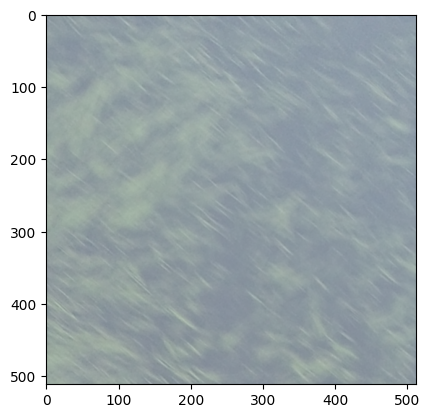

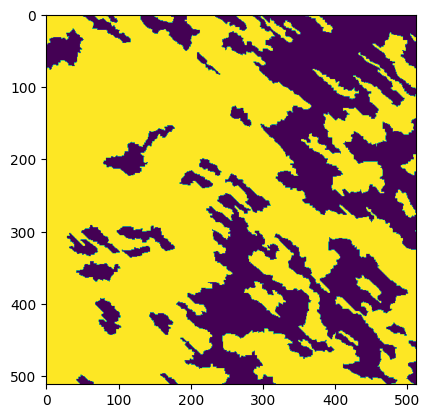

(512, 512, 3)
(512, 512)


In [31]:
for idx in X_val:
    img_path = os.path.join(val_image_folder, idx + '.png')
    mask_path = os.path.join(val_mask_folder, idx + '.png')

    
    # Print out the file paths for debugging
    print("Image Path:", img_path)
    print("Mask Path:", mask_path)
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    plt.imshow(img)
    plt.show()
    plt.imshow(mask)
    plt.show()
    print(np.asarray(img).shape)
    print(np.asarray(mask).shape)
    break

In [32]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms as T
from pathlib import Path
from PIL import Image

class Drone_data(Dataset):
    def __init__(self, img_path, mask_path, grayscale_path, X, mean, std, transform=None, patch=False):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.grayscale_path = Path(grayscale_path)
        self.X = X
        self.mean = mean
        self.std = std
        self.transform = transform
        self.patch = patch

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_path = self.img_path / f'{self.X[idx]}.png'
        mask_path = self.mask_path / f'{self.X[idx]}.png'
        grayscale_path = self.grayscale_path / f'{self.X[idx]}.png'
        
        # Read and convert the image to RGB
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load the additional grayscale image
        grayscale_img = cv2.imread(str(grayscale_path), cv2.IMREAD_GRAYSCALE)
        
        # Replace the red channel with the grayscale image
        img[:, :, 0] = grayscale_img  # Replace the red channel (channel 0)
        
        # Open and convert the mask to grayscale
        mask = Image.open(mask_path)
        mask = mask.convert("L")
        mask = np.array(mask)

        # Map mask values: 255 -> 1
        mask = np.where(mask == 255, 1, 0).astype(np.uint8)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']

        # Convert image to tensor and normalize
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        
        # Convert mask to a tensor
        mask = torch.from_numpy(mask).long()

        if self.patch:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        # Implementation of tile extraction if needed
        pass


In [33]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = Drone_data(
    img_path=train_image_folder,
    mask_path=train_mask_folder,
    grayscale_path=train_glcm_folder,
    X=X_train,
    mean=[0.485, 0.456, 0.406],  # Example mean values
    std=[0.229, 0.224, 0.225],   # Example std values
    transform=t_train,    # Optional Albumentations transform
    patch=False                  # Set to True if you need patch-based data
)

val_set = Drone_data(val_image_folder, val_mask_folder, valid_glcm_folder, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 4

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [34]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=2):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [37]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            #output = torch.argmax(output, dim=1)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    
    total_time_minutes = (time.time() - fit_time) / 60

    # Print the total time
    print('Total time: {:.2f} m'.format(total_time_minutes))

    #print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [38]:
import subprocess

def check_gpu_memory():
    result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
    print(result.stdout.decode('utf-8'))

check_gpu_memory()

Wed Nov  6 11:04:01 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
| 38%   39C    P8             10W /  170W |     724MiB /  12288MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [39]:
max_lr = 1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

torch.save(model, 'Unet-mobilenet2-batchsize4-Alaska_lr-4-glcm-rep-red.pt')

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.618 
Epoch:1/20.. Train Loss: 0.724.. Val Loss: 0.618.. Train mIoU:0.401.. Val mIoU: 0.475.. Train Acc:0.581.. Val Acc:0.654.. Time: 3.88m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.618 >> 0.602 
Epoch:2/20.. Train Loss: 0.618.. Val Loss: 0.602.. Train mIoU:0.486.. Val mIoU: 0.496.. Train Acc:0.659.. Val Acc:0.685.. Time: 2.82m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.602 >> 0.598 
Epoch:3/20.. Train Loss: 0.574.. Val Loss: 0.598.. Train mIoU:0.522.. Val mIoU: 0.487.. Train Acc:0.689.. Val Acc:0.680.. Time: 2.99m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.598 >> 0.522 
saving model...
Epoch:4/20.. Train Loss: 0.544.. Val Loss: 0.522.. Train mIoU:0.556.. Val mIoU: 0.526.. Train Acc:0.715.. Val Acc:0.706.. Time: 2.91m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/20.. Train Loss: 0.535.. Val Loss: 0.572.. Train mIoU:0.564.. Val mIoU: 0.513.. Train Acc:0.722.. Val Acc:0.696.. Time: 2.99m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.572 >> 0.499 
Epoch:6/20.. Train Loss: 0.534.. Val Loss: 0.499.. Train mIoU:0.563.. Val mIoU: 0.547.. Train Acc:0.721.. Val Acc:0.719.. Time: 2.90m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.499 >> 0.476 
Epoch:7/20.. Train Loss: 0.521.. Val Loss: 0.476.. Train mIoU:0.576.. Val mIoU: 0.606.. Train Acc:0.728.. Val Acc:0.764.. Time: 2.87m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:8/20.. Train Loss: 0.517.. Val Loss: 0.497.. Train mIoU:0.574.. Val mIoU: 0.580.. Train Acc:0.729.. Val Acc:0.743.. Time: 2.88m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.497 >> 0.488 
Epoch:9/20.. Train Loss: 0.505.. Val Loss: 0.488.. Train mIoU:0.591.. Val mIoU: 0.564.. Train Acc:0.744.. Val Acc:0.741.. Time: 2.90m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.488 >> 0.484 
Epoch:10/20.. Train Loss: 0.490.. Val Loss: 0.484.. Train mIoU:0.595.. Val mIoU: 0.590.. Train Acc:0.748.. Val Acc:0.754.. Time: 2.85m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.484 >> 0.474 
saving model...
Epoch:11/20.. Train Loss: 0.492.. Val Loss: 0.474.. Train mIoU:0.595.. Val mIoU: 0.579.. Train Acc:0.749.. Val Acc:0.748.. Time: 2.92m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.474 >> 0.457 
Epoch:12/20.. Train Loss: 0.481.. Val Loss: 0.457.. Train mIoU:0.607.. Val mIoU: 0.580.. Train Acc:0.757.. Val Acc:0.752.. Time: 2.90m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.457 >> 0.439 
Epoch:13/20.. Train Loss: 0.473.. Val Loss: 0.439.. Train mIoU:0.604.. Val mIoU: 0.640.. Train Acc:0.756.. Val Acc:0.790.. Time: 2.87m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.439 >> 0.437 
Epoch:14/20.. Train Loss: 0.472.. Val Loss: 0.437.. Train mIoU:0.608.. Val mIoU: 0.636.. Train Acc:0.760.. Val Acc:0.789.. Time: 2.89m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.437 >> 0.424 
Epoch:15/20.. Train Loss: 0.464.. Val Loss: 0.424.. Train mIoU:0.612.. Val mIoU: 0.651.. Train Acc:0.762.. Val Acc:0.798.. Time: 2.89m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:16/20.. Train Loss: 0.462.. Val Loss: 0.434.. Train mIoU:0.621.. Val mIoU: 0.643.. Train Acc:0.767.. Val Acc:0.791.. Time: 2.88m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.434 >> 0.421 
saving model...
Epoch:17/20.. Train Loss: 0.453.. Val Loss: 0.421.. Train mIoU:0.626.. Val mIoU: 0.644.. Train Acc:0.774.. Val Acc:0.799.. Time: 2.88m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.421 >> 0.411 
Epoch:18/20.. Train Loss: 0.446.. Val Loss: 0.411.. Train mIoU:0.629.. Val mIoU: 0.667.. Train Acc:0.775.. Val Acc:0.805.. Time: 2.89m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Decreasing.. 0.411 >> 0.396 
Epoch:19/20.. Train Loss: 0.443.. Val Loss: 0.396.. Train mIoU:0.638.. Val mIoU: 0.673.. Train Acc:0.782.. Val Acc:0.813.. Time: 2.86m


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:20/20.. Train Loss: 0.447.. Val Loss: 0.402.. Train mIoU:0.633.. Val mIoU: 0.665.. Train Acc:0.778.. Val Acc:0.810.. Time: 2.88m
Total time: 58.88 m


In [ ]:
model_path = r'C:\Users\Yang_PC\Documents\Github\ArcgisPro-Customized-Toolbox\Notebook\Unet-mobilenet2-batchsize4-Alaska_lr-4-glcm-rep-red.pt'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load(model_path)
model.to(device)




In [31]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [ ]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [33]:
class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = Path(img_path)
        self.mask_path = Path(mask_path)
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Create image and mask paths using pathlib
        img_file_name = f'{self.X[idx]}.png'
        img_path = self.img_path / img_file_name
        mask_path = self.mask_path / img_file_name
        
        # Read and convert the image to RGB using OpenCV
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Read the mask in grayscale directly using OpenCV
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            # Convert image and mask to NumPy arrays for transformation
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']
        
        # Convert the image to PIL Image (consistent with DroneTestDataset1)
        img = Image.fromarray(img)

        # Convert mask to a PyTorch tensor
        mask = torch.from_numpy(mask).long()

        # Return the image, mask, and file name
        return img, mask, img_file_name

t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test_image_folder, test_mask_folder, X_test, transform=t_test)

In [34]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np


# Updated function to perform inference and save the predicted mask with resizing
def predict_image_mask_miou(model, image, mask, save_file, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()  # Set the model to evaluation mode
    
    # Store original image dimensions before transforming
    original_height, original_width = 512, 512  # PIL Image size: (width, height)
    
    # Apply transformation to the image (e.g., normalization)
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image_tensor = t(image)  # Keep 'image' unchanged for later use
    
    # Move image and mask to the appropriate device
    image_tensor = image_tensor.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():  # Disable gradient calculation for inference
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension for the model
        mask = mask.unsqueeze(0)    # Add batch dimension

        output = model(image_tensor)  # Run model inference
        score = mIoU(output, mask)  # Compute mIoU score
        
        # Get the predicted mask by taking the argmax of the model's output
        pred_mask = torch.argmax(output, dim=1)
        pred_mask = pred_mask.cpu().squeeze(0)  # Move to CPU and remove batch dimension

    # Resize the predicted mask to match the original image size
    pred_mask_resized = cv2.resize(pred_mask.numpy(), (original_width, original_height), interpolation=cv2.INTER_NEAREST)
    
    # Save the resized predicted mask as a grayscale image
    plt.imsave(save_file, pred_mask_resized, cmap='gray')  # Save mask as a grayscale image
    
    return pred_mask_resized, score



def save_predicted_mask_overlay(pred_mask, img_file_name, image_folder, save_file, alpha=0.5):
    """
    Overlays the predicted mask on the original image read from a specified folder, and saves the result.
    
    Parameters:
    - pred_mask: The predicted mask (PyTorch tensor or NumPy array with values 0 and 1).
    - img_file_name: The name of the image file (e.g., 'image_001.png').
    - image_folder: The path to the folder where the original image is located.
    - save_file: The path to save the overlaid image.
    - alpha: The transparency factor for the overlay (default is 0.3 for higher transparency).
    """
    # Build the full image path
    img_path = os.path.join(image_folder, img_file_name)

    # Read the original image from the specified folder
    original_image = Image.open(img_path).convert('RGB')  # Use PIL to read the image
    original_image = np.array(original_image)  # Convert to NumPy array

    # Convert the predicted mask to a NumPy array if it's a PyTorch tensor
    if isinstance(pred_mask, torch.Tensor):
        pred_mask = pred_mask.cpu().numpy()

    # Ensure the predicted mask has 2D shape (height, width)
    if pred_mask.ndim != 2:
        raise ValueError(f"Expected 2D mask, but got shape {pred_mask.shape}")

    # Resize the predicted mask to match the original image size (assuming original image size is 512x512)
    original_height, original_width = original_image.shape[:2]
    pred_mask_resized = cv2.resize(pred_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # Ensure the image is in the correct format (height, width, 3)
    if original_image.ndim != 3 or original_image.shape[2] != 3:
        raise ValueError(f"Expected 3D RGB image, but got shape {original_image.shape}")

    # Create a copy of the original image to modify
    overlay = original_image.copy()

    # Broadcast the mask across the 3 RGB channels (set the mask area to light blue)
    light_blue_color = [78,156,217]  # Light blue RGB
    light_blue_mask = np.zeros_like(overlay)
    light_blue_mask[pred_mask_resized == 1] = light_blue_color  # Light blue for class 1 (object)

    # Blend the original image and the light blue mask, keeping the original image intensity intact
    blended_image = cv2.addWeighted(light_blue_mask, alpha, original_image, 1, 0)

    # Save the blended image
    plt.imsave(save_file, blended_image)
    print(f"Saved overlay image: {save_file}")


In [ ]:
import os
from tqdm import tqdm

# Define the save path for the predicted masks and the folder for original images
original_image_folder = r'D:\ML_Seagrass\SourceData\Alaska\Alaska\test\image'  # Folder with original images
save_path = r'D:\ML_Seagrass\SourceData\Alaska\Alaska\test\overlay'
Pred_mask_path = r'D:\ML_Seagrass\SourceData\Alaska\Alaska\test\predicted'

# Ensure the directories exist
os.makedirs(save_path, exist_ok=True)
os.makedirs(Pred_mask_path, exist_ok=True)

# Loop through all images in the test set
for idx in tqdm(range(len(test_set))):
    image, mask, img_file_name = test_set[idx]  # Get mask and filename from test_set
    
    # Define the save path for the current predicted mask
    save_overlay_file = os.path.join(save_path, f'{img_file_name}')  # Save with filename
    save_predicted_file = os.path.join(Pred_mask_path, f'{img_file_name}')
     
    # Run inference to get the predicted mask
    pred_mask, score = predict_image_mask_miou(model, image, mask, save_predicted_file)
    
    # Save the overlay of the predicted mask on the original image read from `original_image_folder`
    save_predicted_mask_overlay(pred_mask, img_file_name, original_image_folder, save_overlay_file)
    
    # Optionally, log the progress or save additional data
    print(f"Saved predicted mask for {img_file_name} with mIoU score: {score:.3f}")
